# Analysis and Visualization of the NEET Population (15-24 years)

**Author:** Nina and Ligia

**Data Source:** `people_14_25_2023_2024_fullvars.csv`

**Objective:** This notebook analyzes microdata from the PNAD Contínua for Q4 2024, calculates the total NEET population and breaks it down by gender, and generates a chart to visualize the results.

ano — interview year (e.g., 2023, 2024, 2025).
Source: IBGE

trimestre — reference quarter (1 to 4).
Source: IBGE

id_uf — numeric code of the Federative Unit (state) (11=RO … 53=DF). For abbreviation/name, join with br_bd_diretorios_brasil.uf.
Source: Base dos Dados

V1022 – Dwelling location (urban/rural): 1=Urban, 2=Rural.
Source: IBGE (FTP docs)

V2007 – Sex: 1=Male, 2=Female.
Source: IBGE

V2009 – Age: completed years.
Source: IBGE

V2010 – Race/Color: 1=White, 2=Black, 3=Asian (Yellow), 4=Brown (Pardo), 5=Indigenous, 9=Ignored/Not declared.
Source: IBGE

V3002 – Attends school/course? 1=Yes, 2=No (basis for the “E” in NEET).
Source: IBGE

VD4002 – Labor force status in the reference week (derived): 1=Employed, 2=Unemployed, 3=Out of the labor force (basis for the “T” in NEET: not employed).
Source: IBGE (FTP docs)

V4032 – Contributes to a social security institute for this job? 1=Yes, 2=No (asked of employed; “not applicable” if not employed).
Source: IBGE (FTP docs)

VD4019 – Usual earnings from all jobs (derived): monthly nominal income (currency values).
Source: IBGE (FTP docs)

V1028 – Sample weight: historical “household/person weight” with corrections and post-stratification.
Note: for person-level analyses, the more common weight is V1032 (final weight) (and its replicate weights for variance).
Source: IBGE

### 1. Import Libraries

First, we import the necessary libraries for the analysis: `pandas` for data manipulation and `matplotlib` for creating charts.

In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import os

print("Done!")

Done!


In [ ]:
# === ONE-SHOT ADAPTER (final version) ===
# Turns 'dados_rotulados.csv' into 'people_14_25_2023_2024_fullvars.csv'
# Keeps only human-readable columns (no duplicates)

import pandas as pd
import os

NEW_INPUT  = "dados_rotulados.csv"
OLD_OUTPUT = "people_14_25_2023_2024_fullvars.csv"

if not os.path.exists(NEW_INPUT):
    raise FileNotFoundError(f"'{NEW_INPUT}' not found in this folder.")

# 1) Load
df = pd.read_csv(NEW_INPUT)

# 2) Select only needed human-readable columns
need = {
    "ano":"Year",
    "trimestre":"Quarter",
    "age":"Age",
    "weight":"Weight_V1028",
    "id_uf":"UF",                   
    "sex":"Sex_label",              # <- explicit sex label
    "race":"Race_label",            # <- explicit race label
    "in_school":"School_label",
    "occupation_status":"Occupation_label"
}
avail = {k:v for k,v in need.items() if k in df.columns}
df = df[list(avail.keys())].rename(columns=avail).copy()

# 3) Add UF_name (state full name)
uf_name_map = {
    11:'Rondônia',12:'Acre',13:'Amazonas',14:'Roraima',15:'Pará',16:'Amapá',17:'Tocantins',
    21:'Maranhão',22:'Piauí',23:'Ceará',24:'Rio Grande do Norte',25:'Paraíba',26:'Pernambuco',
    27:'Alagoas',28:'Sergipe',29:'Bahia',31:'Minas Gerais',32:'Espírito Santo',33:'Rio de Janeiro',
    35:'São Paulo',41:'Paraná',42:'Santa Catarina',43:'Rio Grande do Sul',50:'Mato Grosso do Sul',
    51:'Mato Grosso',52:'Goiás',53:'Distrito Federal'
}
df["UF"] = pd.to_numeric(df["UF"], errors="coerce")
df["UF_name"] = df["UF"].map(uf_name_map)

# 4) Add Region_label (North, Northeast, Other)
north = {13,12,16,15,14,11,17}  
northeast = {29,23,22,24,26,25,27,28,21}
def region(u):
    try:
        u = int(u)
    except:
        return pd.NA
    if u in north: return "North"
    if u in northeast: return "Northeast"
    return "Other"
df["Region_label"] = df["UF"].apply(region)

# 5) Cast numbers
for c in ["Year","Quarter","Age"]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")
df["Weight_V1028"] = pd.to_numeric(df["Weight_V1028"], errors="coerce").fillna(0)

# 6) Order columns
order = [
    "Year","Quarter","Age","UF","UF_name","Region_label",
    "Sex_label","Race_label","School_label","Occupation_label","Weight_V1028"
]
df = df[[c for c in order if c in df.columns]]

# 7) Save under the old filename so the rest of your notebook works unchanged
df.to_csv(OLD_OUTPUT, index=False, encoding="utf-8")
print(f"✅ Wrote: {OLD_OUTPUT}")
print("Columns ->", list(df.columns))
display(df.head())


✅ Wrote: people_14_25_2023_2024_fullvars.csv
Columns -> ['Year', 'Quarter', 'Age', 'UF', 'UF_name', 'Sex_label', 'School_label', 'Occupation_label', 'Weight_V1028']
Preview:


,Year,Quarter,Age,UF,UF_name,Sex_label,School_label,Occupation_label,Weight_V1028
0,2024,1,23,26,Pernambuco,Male,No,NaN,22.076570
1,2024,1,17,26,Pernambuco,Female,No,NaN,26.997730
2,2024,1,17,26,Pernambuco,Male,No,NaN,22.076570
3,2024,4,18,26,Pernambuco,Female,Yes,NaN,21.363836
4,2024,3,17,26,Pernambuco,Female,Yes,NaN,28.923745


### 2. Load the Data

Now, let's load our pre-processed CSV file into a pandas DataFrame. The script checks if the file exists before attempting to load it.

In [64]:
input_filename = 'people_14_25_2023_2024_fullvars.csv'

if not os.path.exists(input_filename):
    print(f"\nError: The input file '{input_filename}' was not found.")
    print("Please make sure the file is in the same folder as this notebook.")
else:
    try:
        print(f"Loading data from '{input_filename}'...")
        df = pd.read_csv(input_filename)
        print("Data loaded successfully!")
        # Display the first few rows for verification
        display(df.head())
    except Exception as e:
        print(f"\nError: Could not read the file '{input_filename}'. It might be corrupted. Error: {e}")

Loading data from 'people_14_25_2023_2024_fullvars.csv'...
Data loaded successfully!


,Year,Quarter,Age,UF,UF_name,Sex_label,School_label,Occupation_label,Weight_V1028
0,2024,1,23,26,Pernambuco,Male,No,NaN,22.076570
1,2024,1,17,26,Pernambuco,Female,No,NaN,26.997730
2,2024,1,17,26,Pernambuco,Male,No,NaN,22.076570
3,2024,4,18,26,Pernambuco,Female,Yes,NaN,21.363836
4,2024,3,17,26,Pernambuco,Female,Yes,NaN,28.923745


### 3. Filter Data for Analysis

Let's focus our analysis on the relevant data:
1.  **Period:** Q4 2024.
2.  **Age:** Young people between 15 and 24 years old.

In [65]:
#print("Filtering data for Q4 2024 and age between 15-24 years...")

# Filter by the specific year and quarter
df_periodo = df[(df['Year'] == 2024) & (df['Quarter'] == 4)].copy()

# Filter by the target age group
df_age = df_periodo[(df_periodo['Age'] >= 15) & (df_periodo['Age'] <= 24)].copy()


### 4. Identify NEET Population and Calculate Totals

In this step, we apply the NEET definition to filter individuals who are not studying and not working. Then, we use the sample weights (`Weight_V1028`) to estimate the actual population and print the results.

The Weight_V1028 column contains the sample weights, or expansion factors. Since the PNAD survey is based on a statistical sample, not the entire population, each record is assigned a weight that indicates how many people it represents in the total population. By summing these weights for our filtered group (the NEETs), we are extrapolating from the sample to get a statistically valid estimate of the total number of NEETs nationwide. Simply counting the rows would only give us the number of NEETs in the sample itself, not the population estimate we need.

In [66]:
print("Identifying the NEET population and calculating totals...")

# Identify NEET individuals
df_neet = df_age[
    (df_age['School_label'] == 'No') &
    (df_age['Occupation_label'] != 'Employed')
].copy()

# Calculate totals using the sample weights ('Weight_V1028')
total_jovens = df_age['Weight_V1028'].sum()
total_neet = df_neet['Weight_V1028'].sum()
men_neet = df_neet[df_neet['Sex_label'] == 'Male']['Weight_V1028'].sum()
women_neet = df_neet[df_neet['Sex_label'] == 'Female']['Weight_V1028'].sum()

# Calculate percentage
percentagem_neet = (total_neet / total_jovens) * 100 if total_jovens > 0 else 0

print("\n--- Results for Q4 2024 (15-24 years old) ---")
print(f"Total Youth Population: {total_jovens:,.0f}")
print(f"Total NEET Youth: {total_neet:,.0f} ({percentagem_neet:.1f}%)")
print(f"  - NEET Men: {men_neet:,.0f}")
print(f"  - NEET Women: {women_neet:,.0f}")

Identifying the NEET population and calculating totals...

--- Results for Q4 2024 (15-24 years old) ---
Total Youth Population: 30,569,169
Total NEET Youth: 5,769,086 (18.9%)
  - NEET Men: 2,175,034
  - NEET Women: 3,594,053


The IBGE didn't interview everyone in Brazil. That would be a census. Instead, they interviewed a smaller, representative group of people. This is called a sample.

Each person in the sample represents more than just themselves. They also represent a certain number of other people in the real world with similar characteristics (same age, gender, location, etc.).

The Weight_V1028 column is that number. It's a statistical "expansion factor" that tells us how many people in the entire population of Brazil this one interviewed person represents.

### 5. Generate Chart

Finally, we create a bar chart to visualize the distribution of the NEET population, including the total and the breakdown by gender.


Generating the chart...


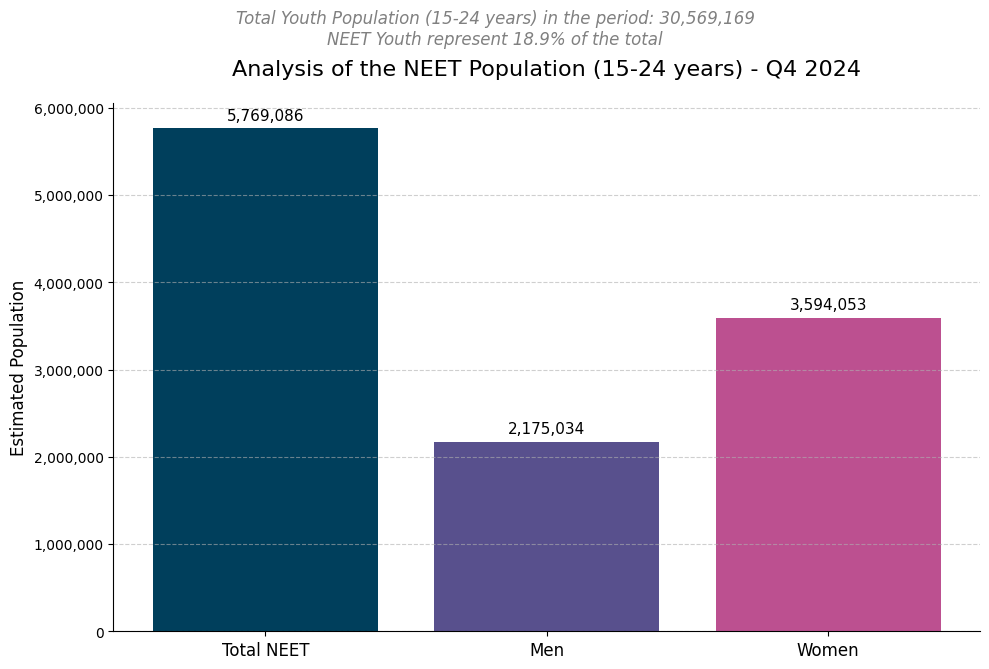

In [67]:
print("\nGenerating the chart...")

# Data for the chart
categories = ['Total NEET', 'Men', 'Women']
valores = [total_neet, men_neet, women_neet]
color = ['#003f5c', '#58508d', '#bc5090']

fig, ax = plt.subplots(figsize=(10, 7))

# Create the bars
bars = ax.bar(categories, valores, color=color)

# Add title and labels
ax.set_title('Analysis of the NEET Population (15-24 years) - Q4 2024', fontsize=16, pad=20)
ax.set_ylabel('Estimated Population', fontsize=12)
ax.tick_params(axis='x', labelsize=12)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.grid(True, linestyle='--', alpha=0.6)
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,.0f}".format(int(x))))

# Add data labels on top of the bars
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2.0, yval + (max(valores) * 0.01), f'{yval:,.0f}', ha='center', va='bottom', fontsize=11)

# Add summary text below the title
summary_text = (
    f"Total Youth Population (15-24 years) in the period: {total_jovens:,.0f}\n"
    f"NEET Youth represent {percentagem_neet:.1f}% of the total"
)
fig.text(0.5, 0.9, summary_text, ha='center', fontsize=12, style='italic', color='gray')

plt.tight_layout(rect=[0, 0, 1, 0.9]) # Adjust layout to make space for text
plt.show()

### 6. State Level Comparison

Now, let's group the NEET population by state (`UF_name`) to see the distribution across the country. We will display a data table and then create a horizontal bar chart for better visualization.

Calculating NEET population by state...

--- Estimated NEET Population (15-24 years) by State - Q4 2024 ---


,NEET Population
UF_name,
São Paulo,"918,470"
Bahia,"486,549"
Minas Gerais,"458,919"
Rio de Janeiro,"441,531"
Pernambuco,"369,626"
Maranhão,"351,715"
Ceará,"342,231"
Pará,"329,467"
Paraná,"210,725"



Generating the chart for state comparison...


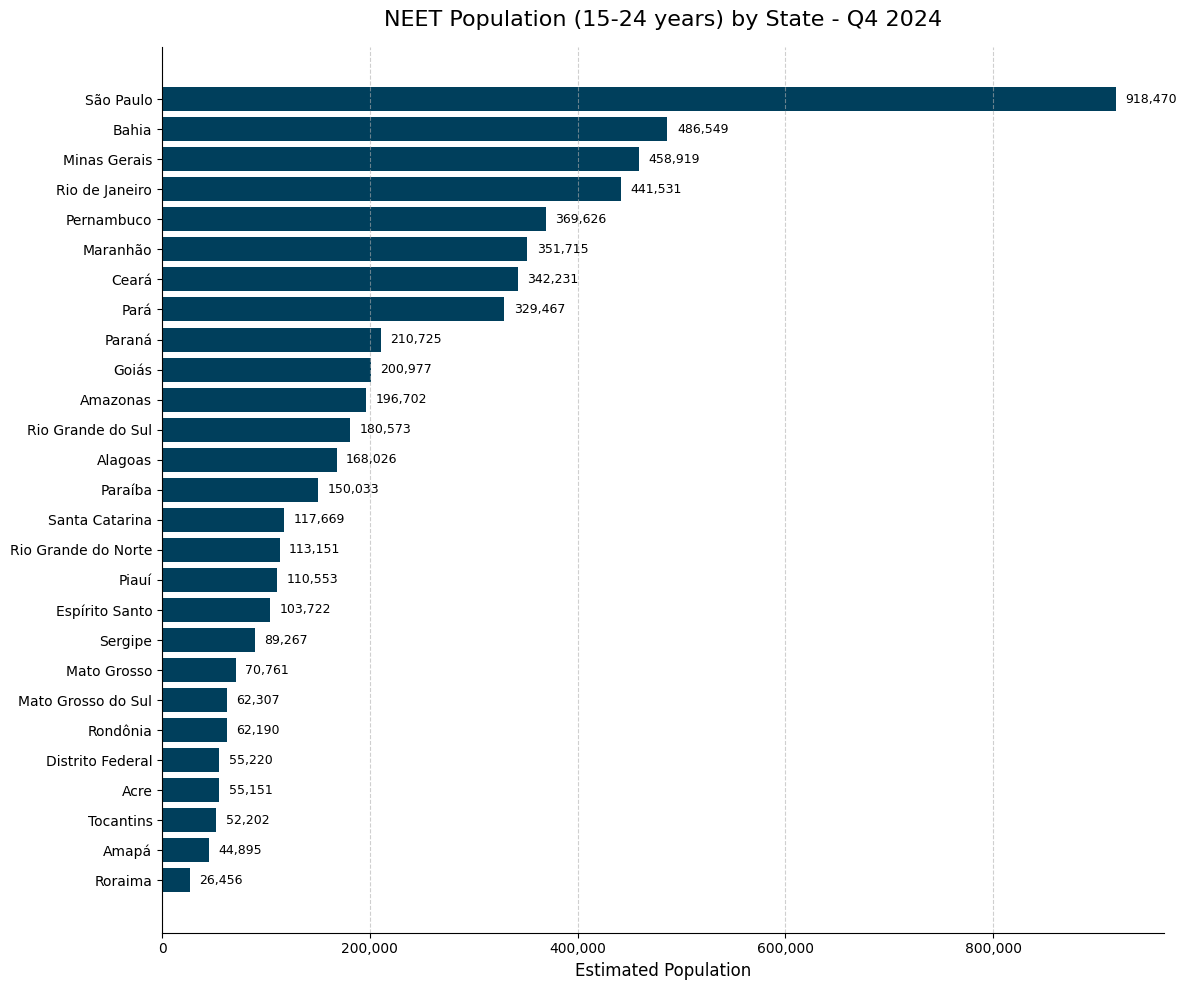

In [68]:
print("Calculating NEET population by state...")

# Group by state and sum the weights to get the estimated population
neet_by_state = df_neet.groupby('UF_name')['Weight_V1028'].sum().sort_values(ascending=False)

# Display the data table for states
print("\n--- Estimated NEET Population (15-24 years) by State - Q4 2024 ---")
display(neet_by_state.apply('{:,.0f}'.format).to_frame(name='NEET Population'))

# --- Generate Chart for State Comparison ---
print("\nGenerating the chart for state comparison...")

fig_state, ax_state = plt.subplots(figsize=(12, 10)) # Taller figure for all states

# Create horizontal bars for better readability
ax_state.barh(neet_by_state.index, neet_by_state.values, color='#003f5c')

# Add title and labels
ax_state.set_title('NEET Population (15-24 years) by State - Q4 2024', fontsize=16, pad=15)
ax_state.set_xlabel('Estimated Population', fontsize=12)
ax_state.invert_yaxis()  # To display the highest value on top

# Formatting
ax_state.xaxis.grid(True, linestyle='--', alpha=0.6)
ax_state.spines['top'].set_visible(False)
ax_state.spines['right'].set_visible(False)
ax_state.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,.0f}".format(int(x))))

# Add data labels to the right of the bars
for i, v in enumerate(neet_by_state.values):
    ax_state.text(v + (neet_by_state.values.max() * 0.01), i, f'{v:,.0f}', va='center', fontsize=9)

plt.tight_layout()
plt.show()

### 7. State Level Comparison by Percentage

The absolute number of NEETs can be misleading since states like São Paulo have a much larger population. A more insightful analysis is to calculate the **percentage of young people who are NEETs** within each state. This normalizes the data and reveals the states with the highest NEET *rate*.

Calculating NEET percentage by state...

--- NEET Rate (%) by State for Youth (15-24) - Q4 2024 ---


,Total_Youth_Population,NEET_Population,NEET_Rate_Percent
UF_name,,,
Acre,1.720869e+05,55151.471296,32.048621
Alagoas,5.676325e+05,168025.891024,29.601174
Maranhão,1.210016e+06,351714.509071,29.066937
Amapá,1.581624e+05,44894.680568,28.385186
Pernambuco,1.425732e+06,369626.438120,25.925372
Ceará,1.324243e+06,342230.823363,25.843500
Amazonas,7.744324e+05,196701.710994,25.399467
Paraíba,6.050176e+05,150032.517651,24.798043
Roraima,1.093301e+05,26456.248157,24.198501



Generating the chart for state comparison by percentage...


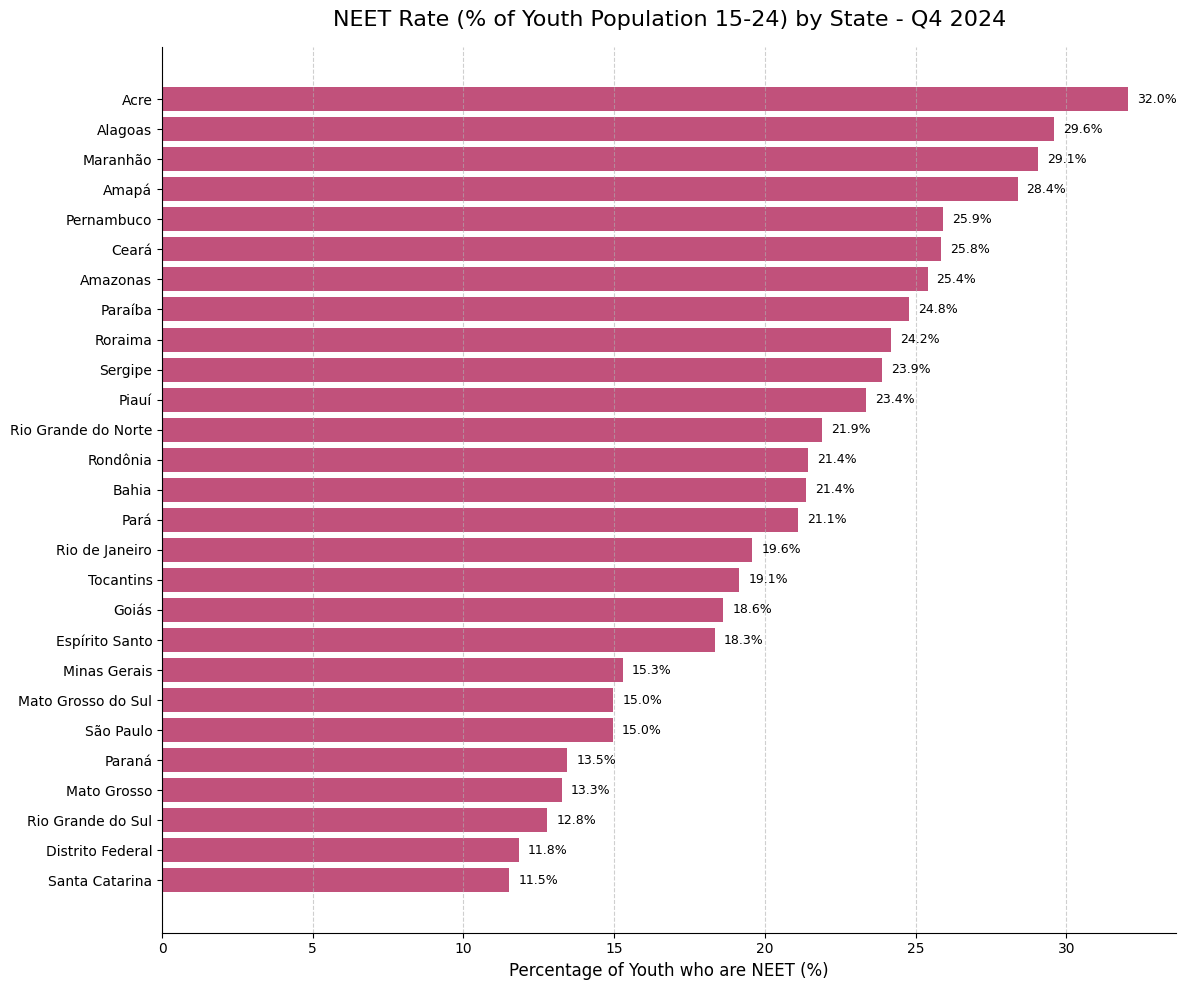

In [69]:
print("Calculating NEET percentage by state...")

# Step 1: Calculate the total youth population (15-24) for each state
total_youth_by_state = df_age.groupby('UF_name')['Weight_V1028'].sum()

# Step 2: Calculate the total NEET population for each state
neet_by_state = df_neet.groupby('UF_name')['Weight_V1028'].sum()

# Step 3: Combine them into a new DataFrame for comparison
df_state_comparison = pd.DataFrame({
    'Total_Youth_Population': total_youth_by_state,
    'NEET_Population': neet_by_state
})

# Step 4: Calculate the NEET rate (percentage)
df_state_comparison['NEET_Rate_Percent'] = \
    (df_state_comparison['NEET_Population'] / df_state_comparison['Total_Youth_Population']) * 100

# Sort the DataFrame by the NEET rate to find the states with the highest proportion
df_state_comparison_sorted = df_state_comparison.sort_values(by='NEET_Rate_Percent', ascending=False)

# Display the resulting data table (without special formatting)
print("\n--- NEET Rate (%) by State for Youth (15-24) - Q4 2024 ---")
display(df_state_comparison_sorted)


# --- Generate Chart for State Comparison by Percentage ---
print("\nGenerating the chart for state comparison by percentage...")

fig_rate, ax_rate = plt.subplots(figsize=(12, 10))

# Get the data for plotting
states = df_state_comparison_sorted.index
rates = df_state_comparison_sorted['NEET_Rate_Percent']

# Create horizontal bars
ax_rate.barh(states, rates, color='#c1517b')

# Add title and labels
ax_rate.set_title('NEET Rate (% of Youth Population 15-24) by State - Q4 2024', fontsize=16, pad=15)
ax_rate.set_xlabel('Percentage of Youth who are NEET (%)', fontsize=12)
ax_rate.invert_yaxis()  # To display the highest rate on top

# Formatting
ax_rate.xaxis.grid(True, linestyle='--', alpha=0.6)
ax_rate.spines['top'].set_visible(False)
ax_rate.spines['right'].set_visible(False)

# Add data labels to the right of the bars
for i, v in enumerate(rates):
    ax_rate.text(v + 0.3, i, f'{v:.1f}%', va='center', fontsize=9, color='black')

plt.tight_layout()
plt.show()

### 8. Deep Dive: Gender and Race Analysis in North & Northeast Regions

Given that the highest NEET rates are concentrated in the North and Northeast, let's investigate the demographic profile of NEETs in these specific regions. This cross-analysis of gender and race will help us understand *who* is most affected where the problem is most severe.

In [73]:
# Define the states belonging to the North and Northeast regions 
north_northeast_states = [
    # North Region
    'Amazonas', 'Pará', 'Acre', 'Rondônia', 'Roraima', 'Amapá', 'Tocantins',
    # Northeast Region
    'Alagoas', 'Bahia', 'Ceará', 'Maranhão', 'Paraíba', 'Pernambuco', 'Piauí', 
    'Rio Grande do Norte', 'Sergipe'
]

# Filter our NEET dataframe to only include these states
df_neet_regions = df_neet[df_neet['UF_name'].isin(north_northeast_states)].copy()

if df_neet_regions.empty:
    print("No NEET data found for the selected North and Northeast states.")
else:
    # Group by Race and Gender, then sum the weights to get the population estimate
    regional_analysis = df_neet_regions.groupby(['Race_label', 'Sex_label'])['Weight_V1028'].sum()
    
    # Reformat the data for easier plotting (pivot)
    regional_analysis_pivot = regional_analysis.unstack()

    print("\n--- Estimated NEET Population by Race and Gender in N/NE Regions (Q4 2024) ---")
    display(regional_analysis_pivot.applymap('{:,.0f}'.format))

    # --- Generate Chart for the Regional Deep Dive ---
    print("\nGenerating chart for the regional deep dive...")
    
    ax = regional_analysis_pivot.plot(
        kind='bar', 
        figsize=(14, 8),
        color={'Male': '#58508d', 'Female': '#bc5090'},
        width=0.8
    )

    # Add titles and labels
    ax.set_title('NEET Population Profile in High-Rate Regions (North & Northeast)', fontsize=16, pad=20)
    ax.set_ylabel('Estimated Population')
    ax.set_xlabel('Race / Color')
    ax.tick_params(axis='x', labelrotation=45)
    ax.yaxis.grid(True, linestyle='--', alpha=0.7)
    ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,.0f}".format(int(x))))
    
    # Add data labels to each bar
    for container in ax.containers:
        ax.bar_label(container, fmt='{:,.0f}', label_type='edge', padding=3)

    plt.legend(title='Gender')
    plt.tight_layout()
    plt.show()

KeyError: 'Race_label'

### 9. Gender Breakdown of NEET Population by State

Following the regional analysis, let's examine the gender distribution of the NEET population within each state. This will help us identify states where the gender gap among NEET youth is more pronounced, providing deeper insights into local socioeconomic factors.


--- Estimated NEET Population by Gender in N/NE States (Q4 2024) ---


C:\Users\ligia\AppData\Local\Temp\ipykernel_5236\2189601830.py:15: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  display(gender_pivot_sorted_regions[['Male', 'Female', 'Total_NEET']].applymap('{:,.0f}'.format))


Sex_label,Male,Female,Total_NEET
UF_name,,,
Roraima,"8,863","17,593","26,456"
Amapá,"13,372","31,523","44,895"
Tocantins,"19,605","32,596","52,202"
Acre,"24,577","30,574","55,151"
Rondônia,"19,726","42,465","62,190"
Sergipe,"30,788","58,479","89,267"
Piauí,"41,463","69,090","110,553"
Rio Grande do Norte,"51,128","62,023","113,151"
Paraíba,"58,489","91,543","150,033"


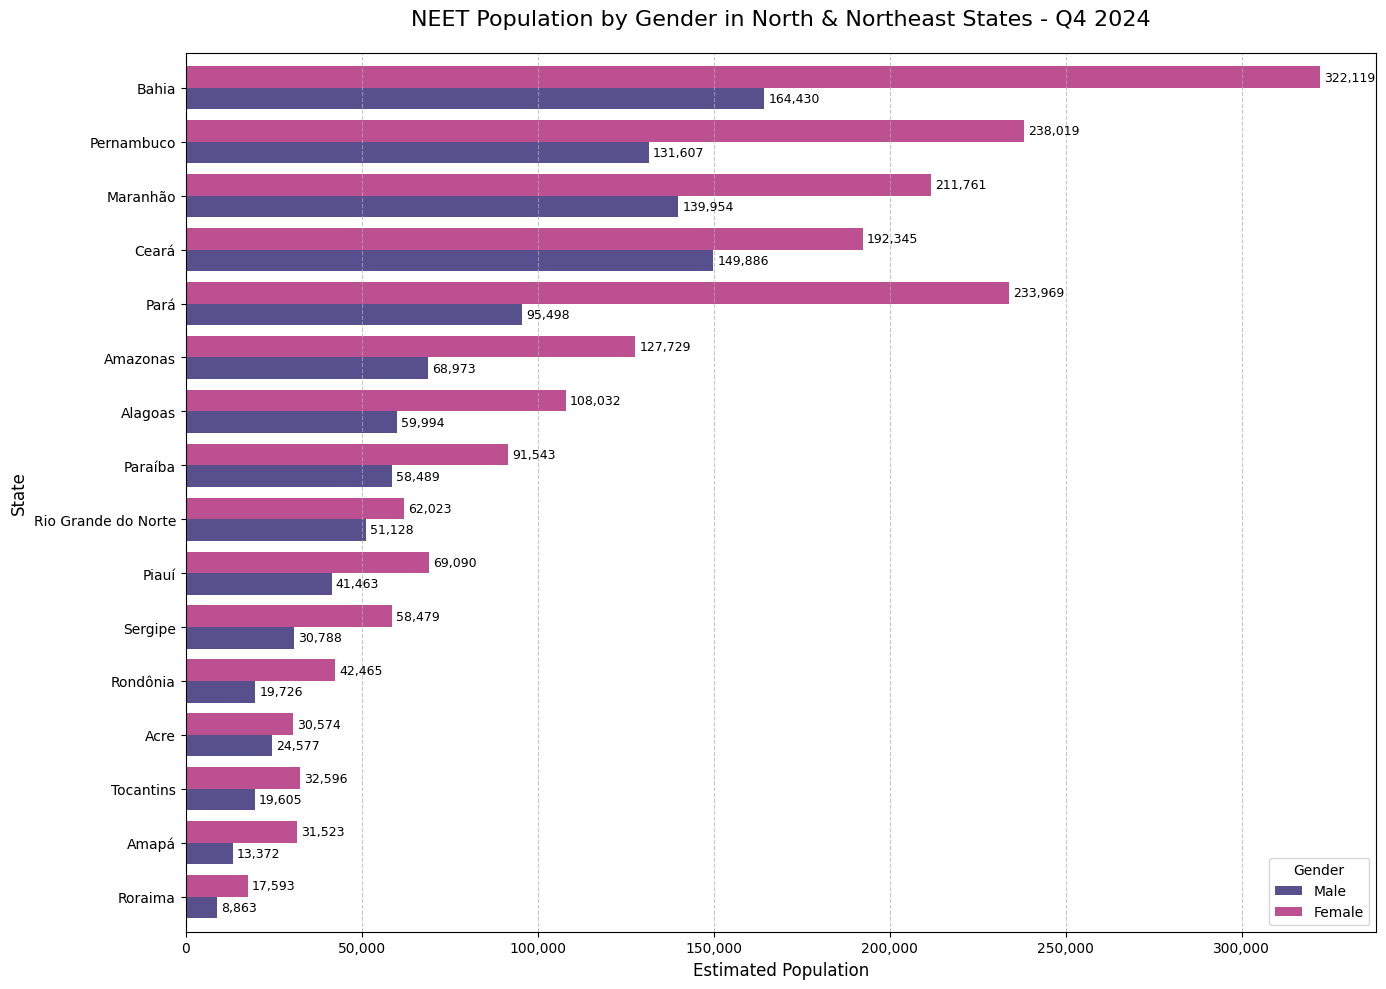

In [ ]:
# Filter our main NEET dataframe to only include these states
df_neet_regions = df_neet[df_neet['UF_name'].isin(north_northeast_states)].copy()

# Group by state (UF_name) and gender (Sex_label), then sum the weights
gender_by_state_regions = df_neet_regions.groupby(['UF_name', 'Sex_label'])['Weight_V1028'].sum()

# Pivot the data to have states as rows and genders as columns
gender_pivot_regions = gender_by_state_regions.unstack().fillna(0)

# Add a 'Total' column to sort by, making the chart more organized
gender_pivot_regions['Total_NEET'] = gender_pivot_regions['Male'] + gender_pivot_regions['Female']
gender_pivot_sorted_regions = gender_pivot_regions.sort_values(by='Total_NEET', ascending=True)

print("\n--- Estimated NEET Population by Gender in N/NE States (Q4 2024) ---")
display(gender_pivot_sorted_regions[['Male', 'Female', 'Total_NEET']].applymap('{:,.0f}'.format))


ax = gender_pivot_sorted_regions[['Male', 'Female']].plot(
    kind='barh', # Horizontal bar chart is better for many categories
    figsize=(14, 10),
    color={'Male': '#58508d', 'Female': '#bc5090'},
    width=0.8
)

# Add titles and labels
ax.set_title('NEET Population by Gender in North & Northeast States - Q4 2024', fontsize=16, pad=20)
ax.set_xlabel('Estimated Population', fontsize=12)
ax.set_ylabel('State', fontsize=12)

# Formatting
ax.xaxis.grid(True, linestyle='--', alpha=0.7)
ax.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,.0f}".format(int(x))))
ax.legend(title='Gender')

# Add data labels for each bar
for container in ax.containers:
    ax.bar_label(container, fmt='{:,.0f}', label_type='edge', padding=3, fontsize=9)

plt.tight_layout()
plt.show()

### 10. Conclusion and Next Step: Focusing on the Northeast Region

After comparing the absolute number of NEETs and the gender distribution in the North and Northeast regions, a clear pattern has emerged. While both regions exhibit high NEET rates, the **Northeast region presents a challenge on a significantly larger scale**.

**Key Observations:**

1.  **Magnitude:** The absolute number of NEETs in major Northeastern states (such as Bahia, Pernambuco, and Ceará) far exceeds those in the North. The sheer volume of the affected population is concentrated in the Northeast.
2.  **Gender Disparity:** The gap between female and male NEETs is consistently and dramatically wider across all Northeastern states. This suggests that gender-related socioeconomic factors may be a more pronounced driver of the NEET phenomenon in this region.
3.  **Systemic Issue:** Unlike the North, where some states have relatively lower numbers, the problem in the Northeast is widespread and severe across all its states, indicating a more systemic challenge.

Based on these findings, we conclude that the **Northeast region should be the primary focus of our subsequent deep-dive analysis**. By concentrating our efforts here, we can gain more impactful insights into the core of the NEET issue in Brazil.

**Next Step:** We will perform a detailed analysis of the NEET population in the Northeast states, broken down by both **gender and race/color**.

### 11. Detailed Profile of NEETs in Northeast States

Now we'll conduct the final and most detailed part of our analysis. We will loop through each state in the Northeast and generate a specific chart for each one. This will break down the NEET population by **age group**, **race/color**, and **gender**, providing a deep and localized understanding of the NEET profile in the region where the issue is most critical.

C:\Users\ligia\AppData\Local\Temp\ipykernel_5236\4194287214.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  state_analysis = df_state.groupby(['Age_Group', 'Race_label', 'Sex_label'])['Weight_V1028'].sum().unstack().fillna(0)


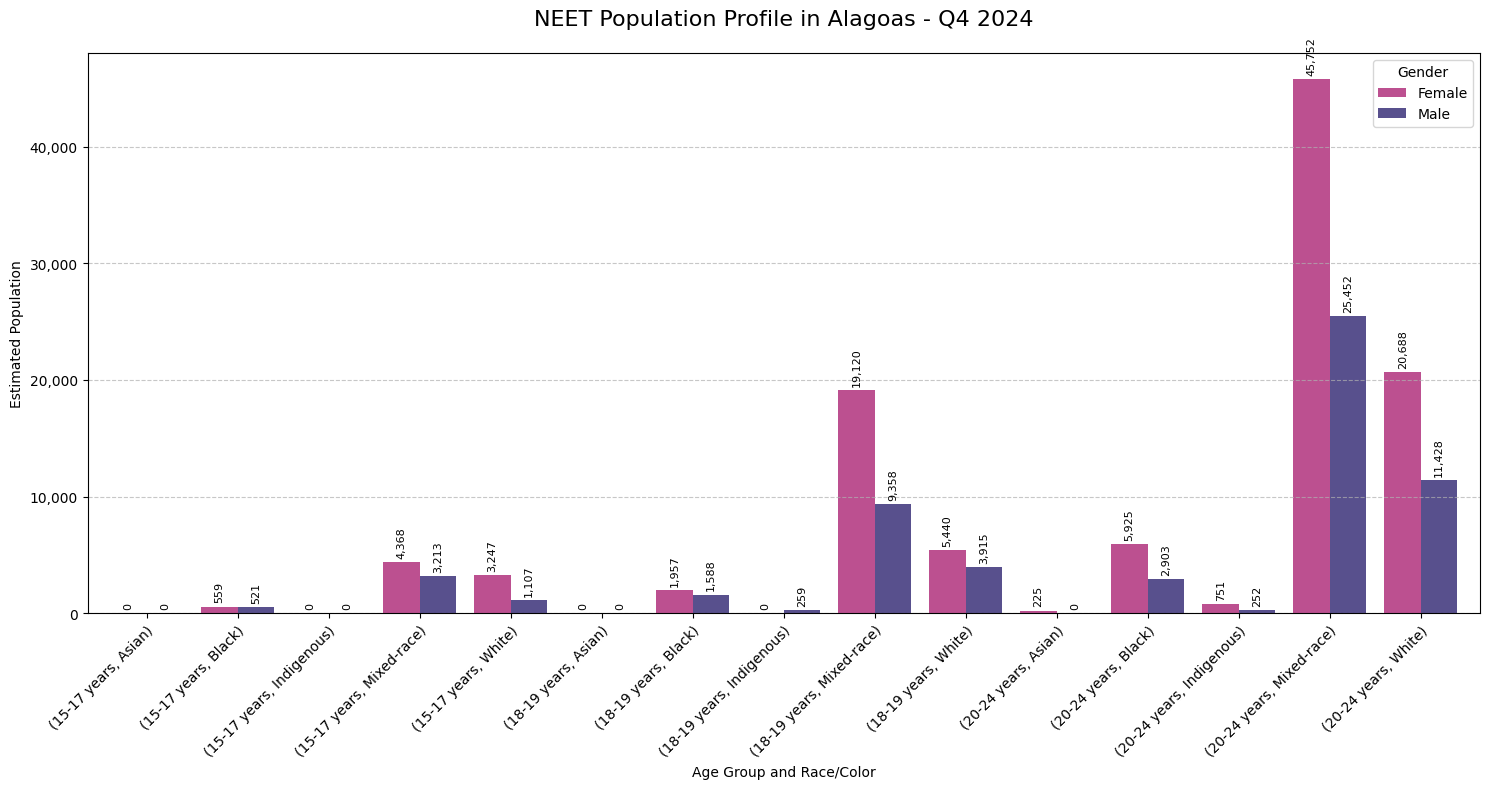

C:\Users\ligia\AppData\Local\Temp\ipykernel_5236\4194287214.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  state_analysis = df_state.groupby(['Age_Group', 'Race_label', 'Sex_label'])['Weight_V1028'].sum().unstack().fillna(0)


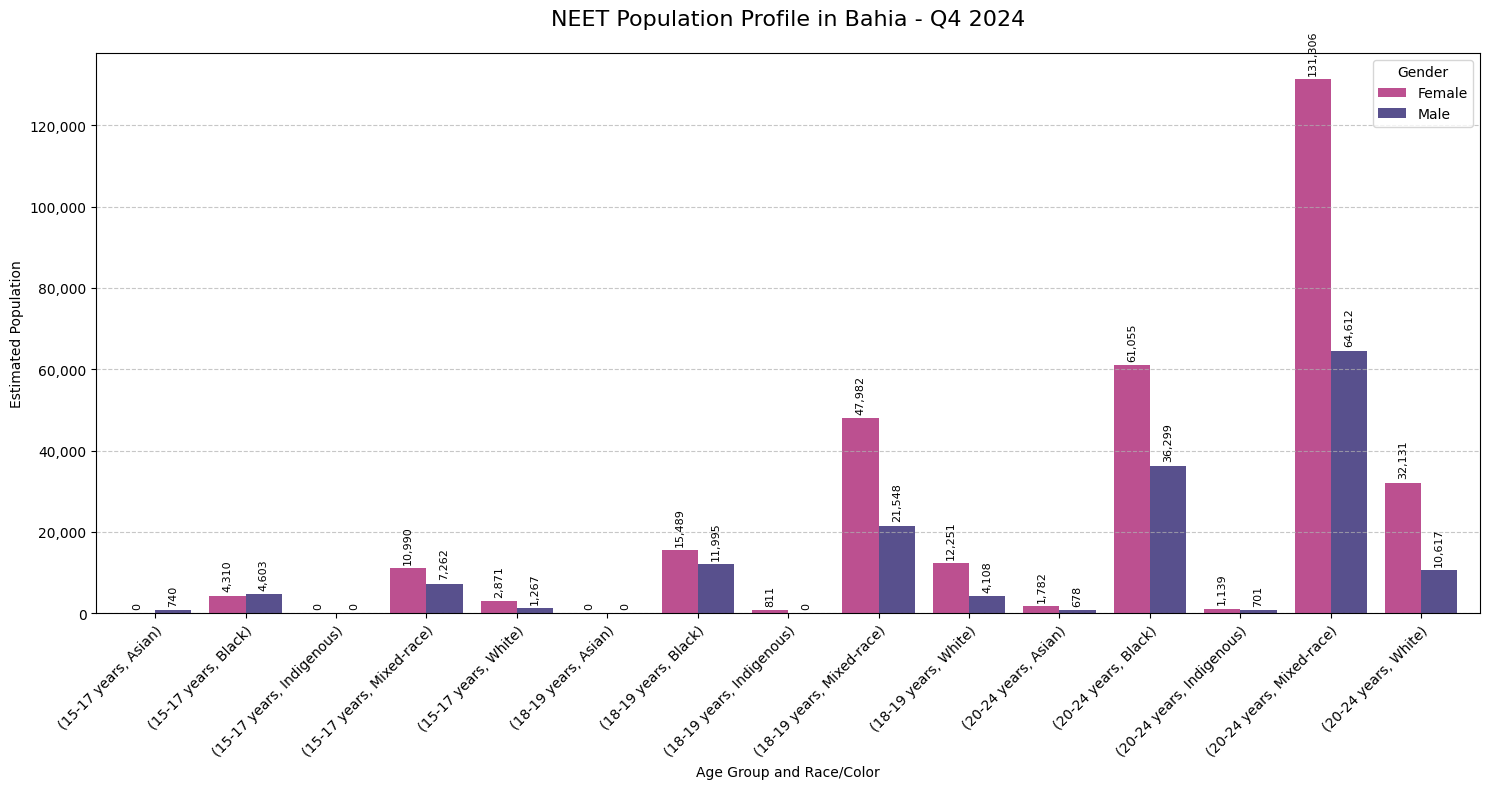

C:\Users\ligia\AppData\Local\Temp\ipykernel_5236\4194287214.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  state_analysis = df_state.groupby(['Age_Group', 'Race_label', 'Sex_label'])['Weight_V1028'].sum().unstack().fillna(0)


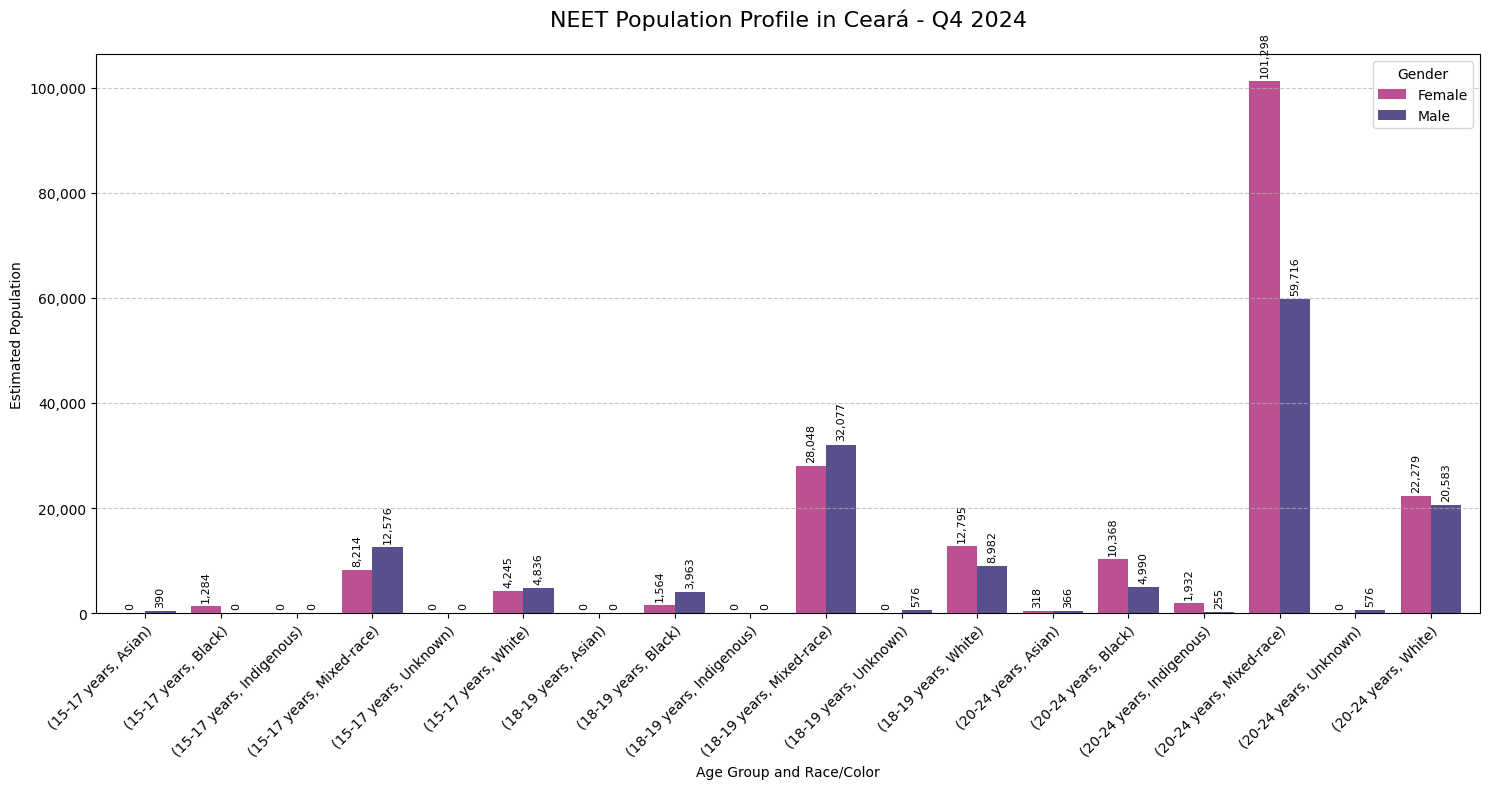

C:\Users\ligia\AppData\Local\Temp\ipykernel_5236\4194287214.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  state_analysis = df_state.groupby(['Age_Group', 'Race_label', 'Sex_label'])['Weight_V1028'].sum().unstack().fillna(0)


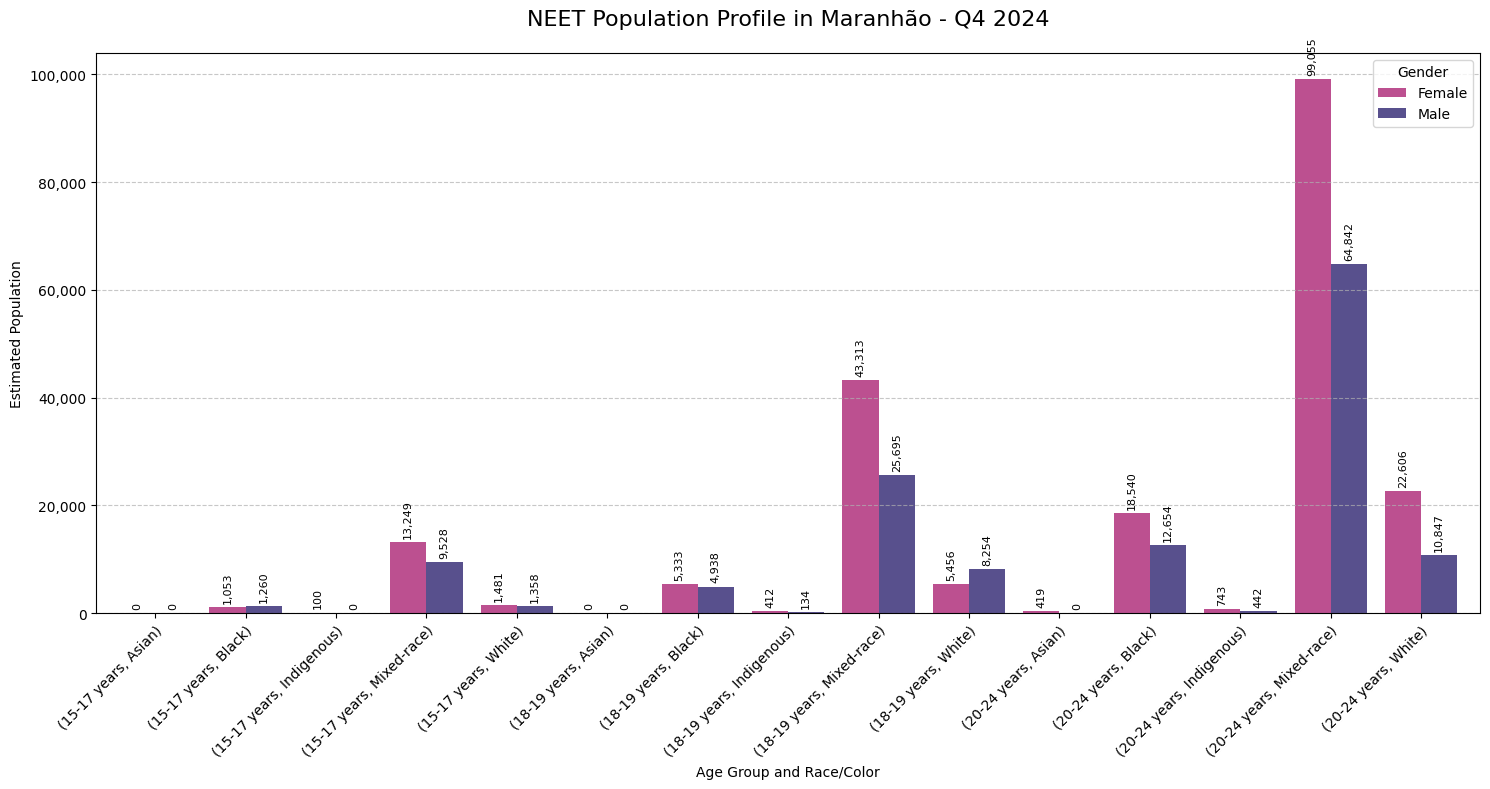

C:\Users\ligia\AppData\Local\Temp\ipykernel_5236\4194287214.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  state_analysis = df_state.groupby(['Age_Group', 'Race_label', 'Sex_label'])['Weight_V1028'].sum().unstack().fillna(0)


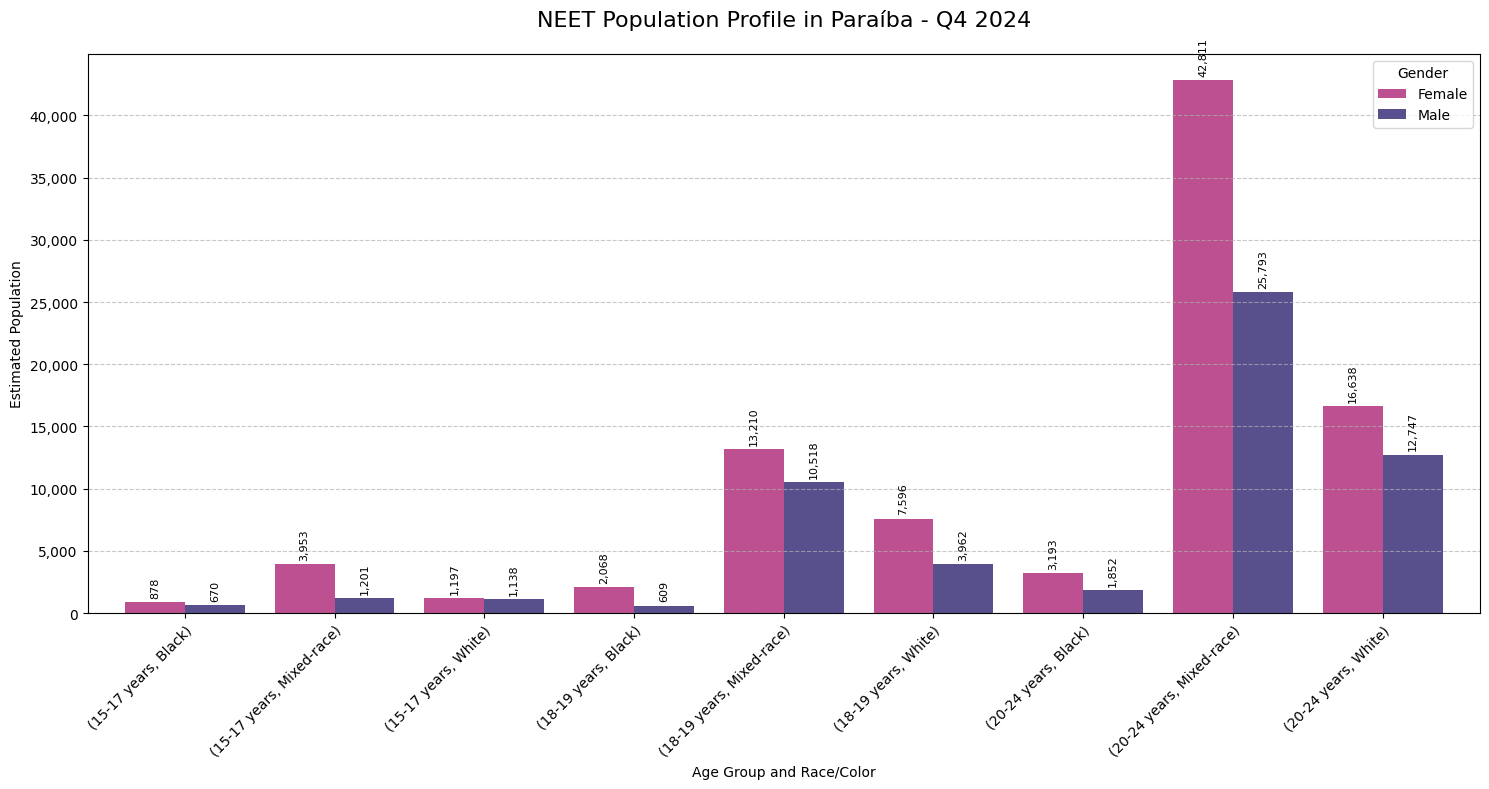

C:\Users\ligia\AppData\Local\Temp\ipykernel_5236\4194287214.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  state_analysis = df_state.groupby(['Age_Group', 'Race_label', 'Sex_label'])['Weight_V1028'].sum().unstack().fillna(0)


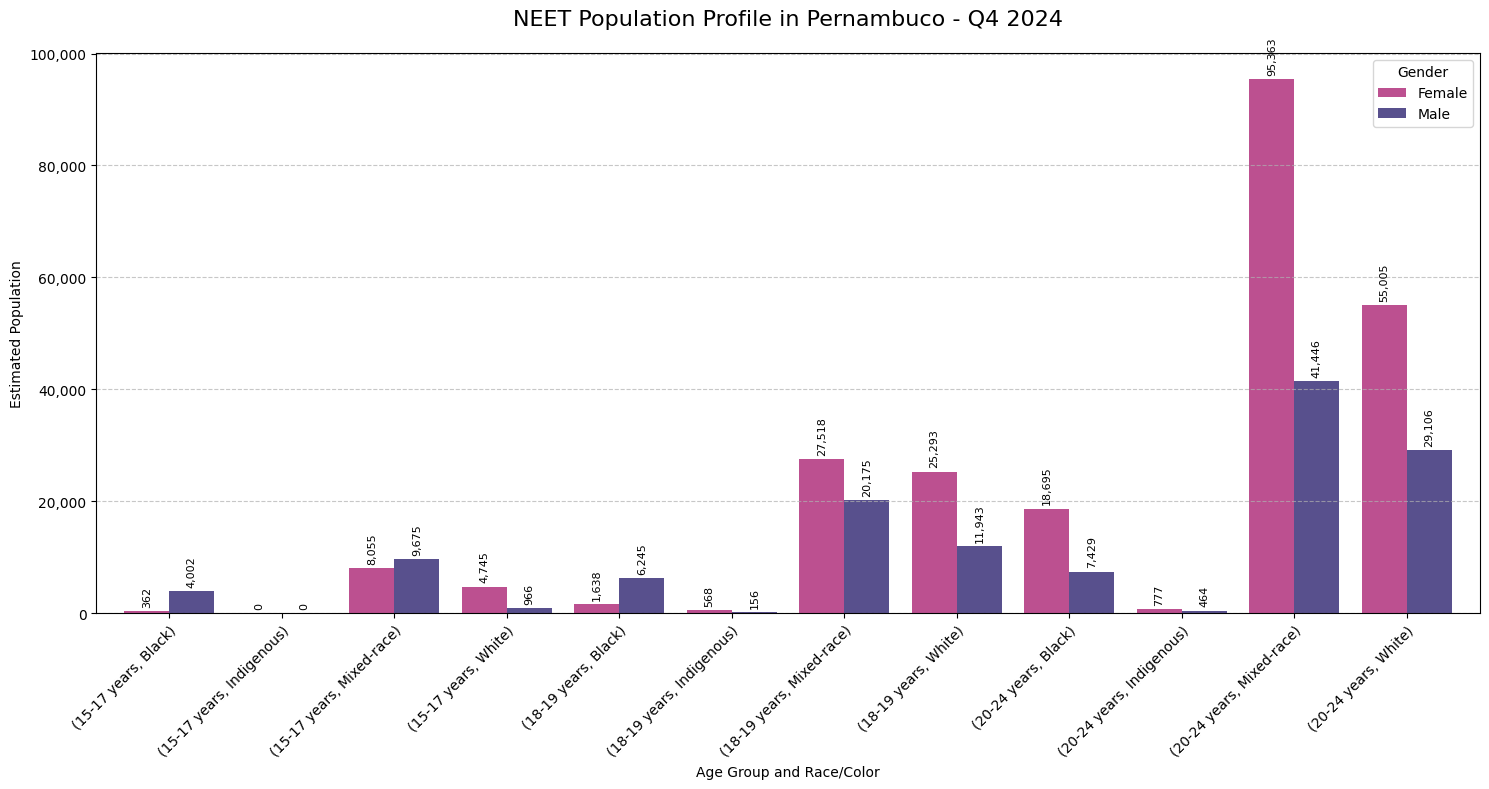

C:\Users\ligia\AppData\Local\Temp\ipykernel_5236\4194287214.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  state_analysis = df_state.groupby(['Age_Group', 'Race_label', 'Sex_label'])['Weight_V1028'].sum().unstack().fillna(0)


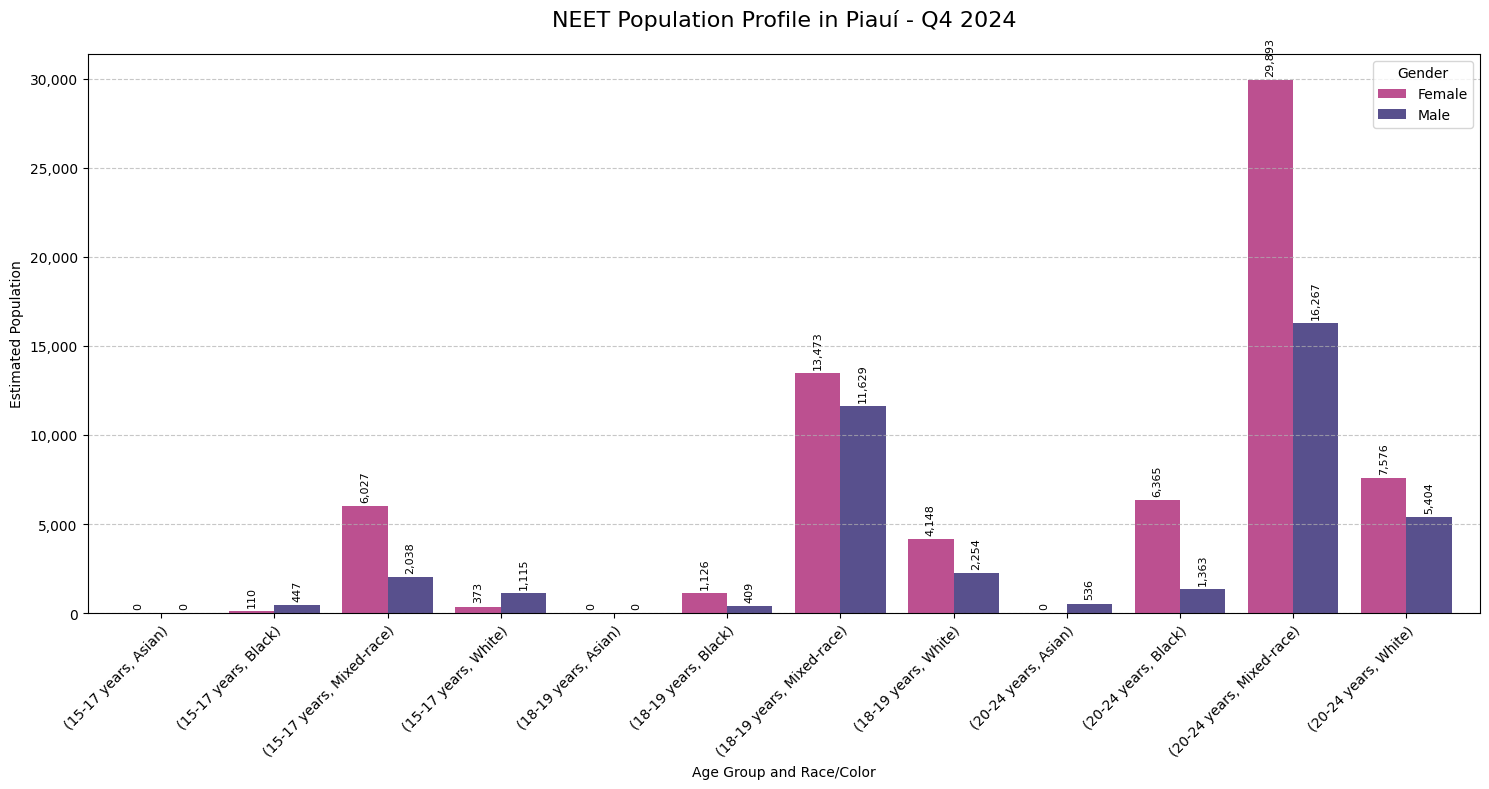

C:\Users\ligia\AppData\Local\Temp\ipykernel_5236\4194287214.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  state_analysis = df_state.groupby(['Age_Group', 'Race_label', 'Sex_label'])['Weight_V1028'].sum().unstack().fillna(0)


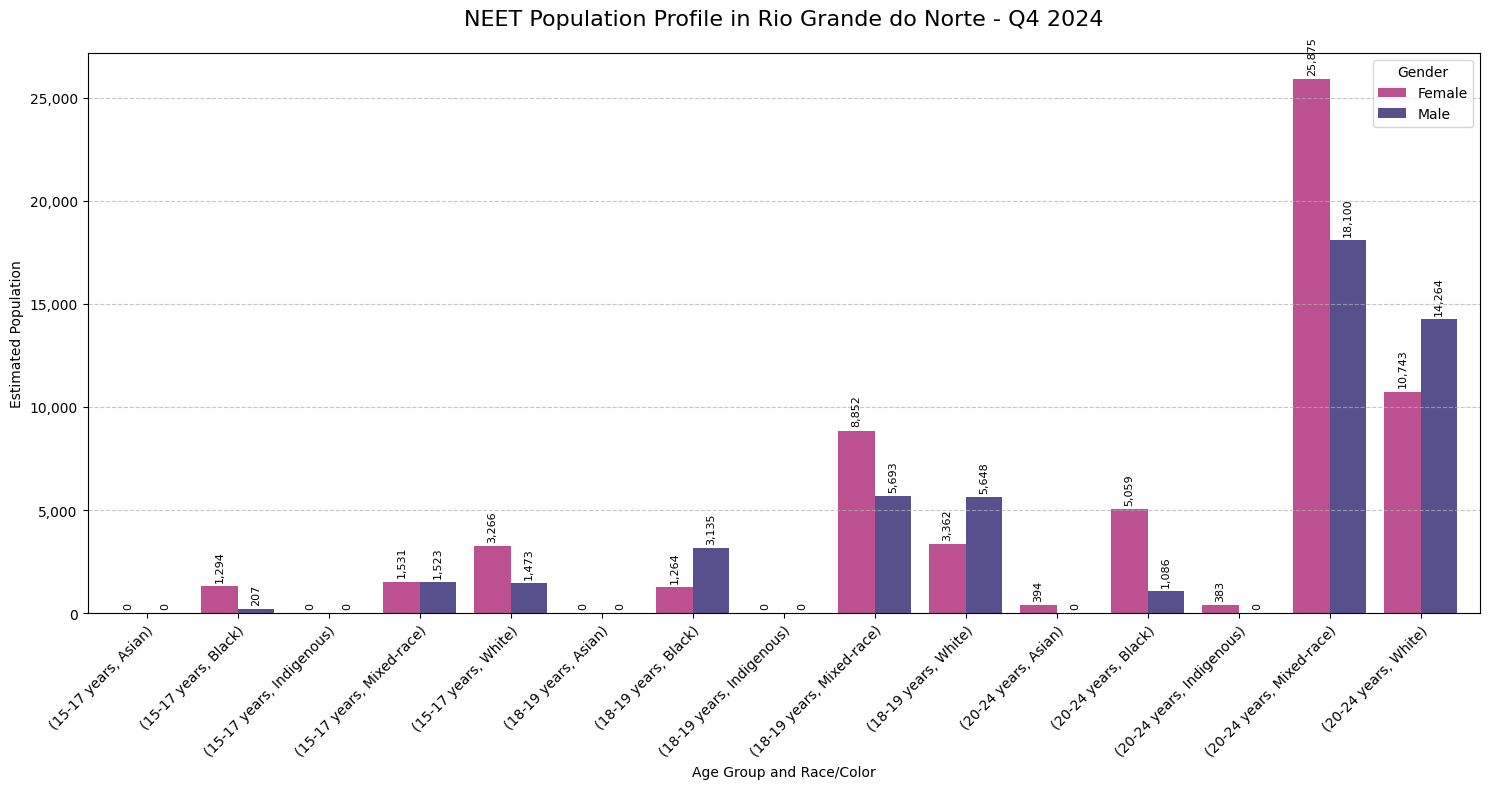

C:\Users\ligia\AppData\Local\Temp\ipykernel_5236\4194287214.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  state_analysis = df_state.groupby(['Age_Group', 'Race_label', 'Sex_label'])['Weight_V1028'].sum().unstack().fillna(0)


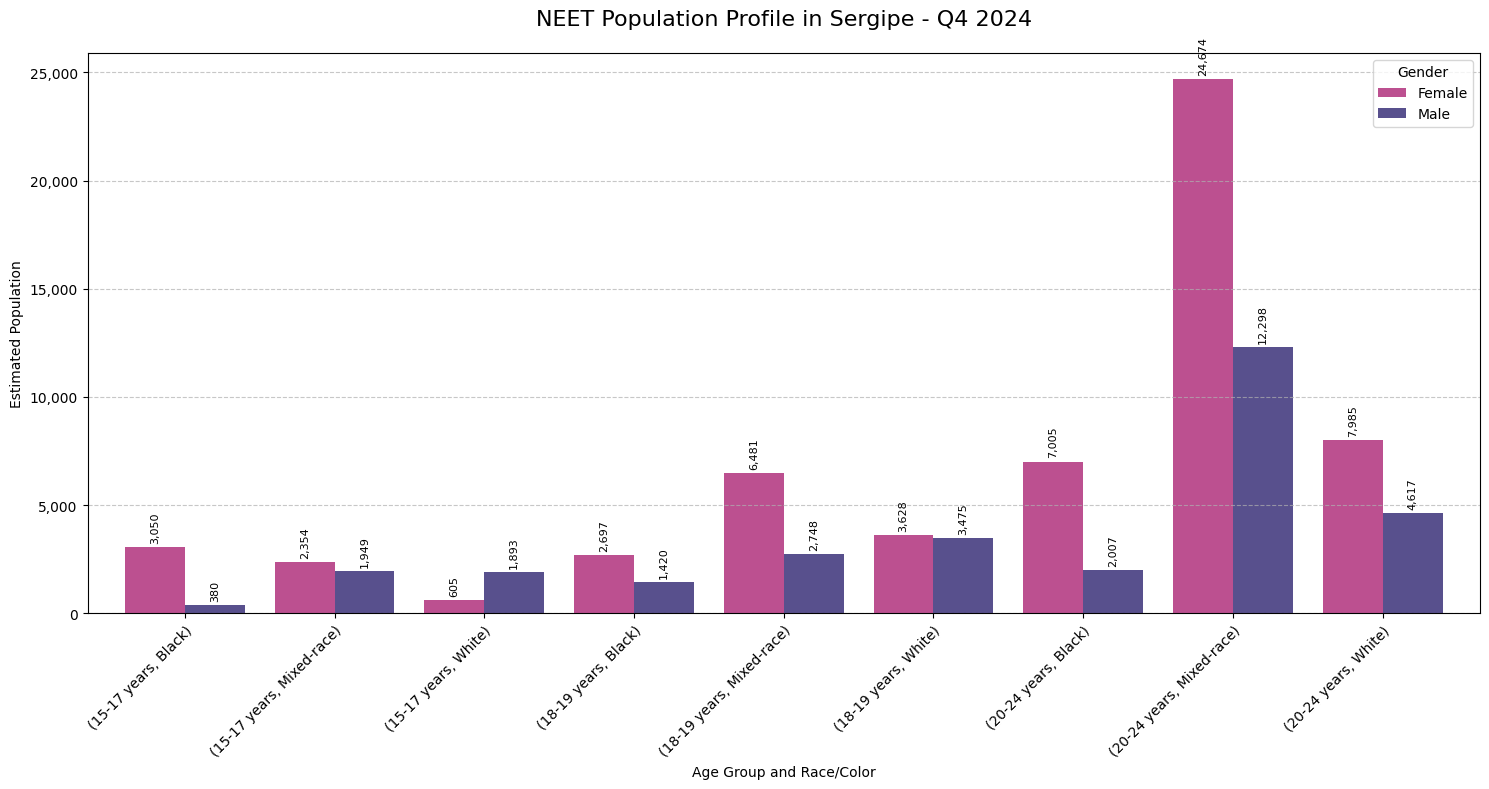

In [ ]:
# Define the list of Northeast states
northeast_states = [
    'Alagoas', 'Bahia', 'Ceará', 'Maranhão', 'Paraíba', 'Pernambuco', 'Piauí', 
    'Rio Grande do Norte', 'Sergipe'
]

# Filter the main NEET dataframe to only include these states
df_neet_nordeste = df_neet[df_neet['UF_name'].isin(northeast_states)].copy()

# Create age groups for better visualization
age_bins = [14, 17, 19, 24]
age_labels = ['15-17 years', '18-19 years', '20-24 years']
df_neet_nordeste['Age_Group'] = pd.cut(df_neet_nordeste['Age'], bins=age_bins, labels=age_labels, right=True)

# Loop through each state and create a dedicated chart
for state in sorted(northeast_states):
   
    df_state = df_neet_nordeste[df_neet_nordeste['UF_name'] == state]
  

    state_analysis = df_state.groupby(['Age_Group', 'Race_label', 'Sex_label'])['Weight_V1028'].sum().unstack().fillna(0)
    

    ax = state_analysis.plot(
        kind='bar',
        figsize=(15, 8),
        color={'Male': '#58508d', 'Female': '#bc5090'},
        width=0.8
    )
    
    ax.set_title(f'NEET Population Profile in {state} - Q4 2024', fontsize=16, pad=20)
    ax.set_ylabel('Estimated Population')
    ax.set_xlabel('Age Group and Race/Color')
    
    # set properties on the labels directly, which is more robust.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    ax.tick_params(axis='x', labelsize=10) # Setting just the size here is fine.
    
    ax.yaxis.grid(True, linestyle='--', alpha=0.7)
    ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,.0f}".format(int(x))))
    ax.legend(title='Gender')
    
    for container in ax.containers:
        ax.bar_label(container, fmt='{:,.0f}', label_type='edge', padding=3, fontsize=8, rotation=90)
    
    plt.tight_layout()
    plt.show()

### 12. Final Conclusion: The Core Profile of a NEET Youth in the Northeast

After a detailed, multi-layered analysis of the PNAD Contínua microdata for Q4 2024, a powerful and consistent pattern has emerged across all states in the Northeast region.

Our investigation reveals that the demographic group most disproportionately affected by the NEET phenomenon is composed of **Mixed-race ('Parda') women between the ages of 20 and 24**.

This finding is not merely a statistic; it points to a deep-seated issue of intersectional inequality. The combination of three distinct factors—**gender, race, and a critical life transition stage**—creates a triple vulnerability that places this specific group at the highest risk:

1.  **Gender:** Women in this age group are more likely to be pushed out of the workforce or education system due to caregiving responsibilities (children, home, etc.), a burden that is not equally shared by men.
2.  **Race:** The Mixed-race population, alongside the Black population, historically faces greater structural barriers to quality education and formal employment opportunities compared to the White population.
3.  **Age:** The 20-24 age bracket is a crucial period for transitioning from higher education to a stable career. A failure at this stage can have long-lasting consequences on an individual's professional and personal life.

Therefore, we conclude that any public policy or initiative aimed at tackling the NEET issue in Brazil, particularly in the Northeast, must be designed with a strong focus on gender and race. Addressing the specific challenges faced by young, Mixed-race women is fundamental to creating any meaningful and effective change.